In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr
import pandas as pd
import os
from tqdm import tqdm, tnrange, tqdm_notebook

DF = pd.DataFrame
arr = np.array

# 读取数据集

In [3]:
dirPath2 = "data preprocessed\\wordvec_6B_50d - TA version" 


trainSet = np.loadtxt(dirPath2 + '\\train.csv', delimiter=",")
validateSet = np.loadtxt(dirPath2 + '\\validate.csv', delimiter=",")
testSet = np.loadtxt(dirPath2 + '\\test.csv', delimiter=",")

dirPath = ".\\data preprocessed\\tf-idf"
trainSetLabel = np.loadtxt(dirPath + '\\train_label.csv', delimiter=",")
validateSetLabel = np.loadtxt(dirPath + '\\validate_label.csv', delimiter=",")

trainSet.shape, validateSet.shape, testSet.shape
trainSetLabel.shape, validateSetLabel.shape

((43766, 50), (18756, 50), (8671, 50))

((43766,), (18756,))

# KNN

In [4]:
def knn_classify(dataSet, labels, k, inputVector):
    '''使用knn对输入的向量进行分类，使用欧式距离'''
    #得到输入向量与数据集的差值的平方
    diffMat = (dataSet - inputVector)**2
    #计算每一行上元素的和
    distancesSquare = diffMat.sum(axis=1)
    #可以不用计算距离，用距离的平方也可以，这样效率更高
    #print(distancesSquare)
    #得到 K 个近邻的下标
    kNeighborsIndex  = distancesSquare.argpartition(k-1)[0:k]
    
    #计算 K 个近邻的距离倒数
    kDatas = 1/distancesSquare[kNeighborsIndex]
    #得到 对应的 K 个标签
    kLabels = labels[kNeighborsIndex]
    
    predictLabel = np.NAN
    maxDis = -np.inf
    for i in np.unique(kLabels):
        dis = np.sum(kDatas[kLabels==i]) 
        #print(dis)
        if dis > maxDis:
            maxDis = dis
            predictLabel = i
    #返回分类结果
    return predictLabel

##############测试程序#######################
knn_classify(arr([[1,1,0,0],
              [0,1,1,1],
              [1,0,0,1]]), arr([1, 0, 1]), 3, arr([0,1,1,0]))
##############测试程序#######################

0

# 计算平均准确率

In [5]:
def calcAvg(predict, actual):
    all_labels = list(set(actual))
    tot = 0.0
    for i in all_labels:
        counter = Counter(predict[actual == i] == i)
        hit_num, miss_num = counter[True], counter[False]
        tot += hit_num / (hit_num + miss_num)
    return tot/len(all_labels)

calcAvg(arr([1,2,3]), arr([3,2,1]))

0.3333333333333333

In [7]:
trainSet[0,:]

array([  1.23829862e-01,   2.50570797e-01,  -1.61819230e-01,
        -1.54766699e-01,   1.77189946e-01,  -1.05322620e-01,
        -5.22355270e-01,   1.53324973e-01,  -1.01816743e-01,
        -1.29281297e-01,  -1.24611497e-01,  -1.22830554e-01,
        -8.66971216e-02,  -5.61720270e-02,   1.92646162e-01,
         4.90908432e-02,   8.09077027e-02,  -1.58393378e-02,
        -3.72756054e-01,  -2.65370581e-01,   1.33082757e-01,
         2.64064797e-01,   5.42573469e-02,   2.07145297e-01,
         1.06557608e-01,  -8.76695959e-01,  -1.71635162e-01,
         1.32052527e-01,   2.48080306e-01,  -1.11433405e-01,
         2.02514480e+00,   1.92924689e-01,  -1.03246661e-01,
         3.19465838e-02,   7.84354959e-02,  -6.87133514e-02,
        -3.31299459e-02,   5.07176216e-02,   2.83994473e-02,
        -1.19154784e-01,  -3.07002162e-02,   2.40311811e-02,
         1.00482824e-01,  -5.49468919e-02,   5.14289324e-02,
         1.28533338e-01,  -9.48613378e-02,  -2.18191851e-01,
         1.77455676e-03,

In [20]:
def run_knn_classify(dataSet, k):
    ansLabel = []
    for i in tnrange(len(dataSet), leave=False):
        ansLabel.append(knn_classify(trainSet, trainSetLabel, k, dataSet[i]))
    return arr(ansLabel)

def getTestAvg(k):
    ansLabel = run_knn_classify(validateSet, k)
    return calcAvg(ansLabel, validateSetLabel)


In [30]:
testRange = np.arange(1, 15)
testRange

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [25]:
avgs = []
for k in tnrange(1, len(testRange)+1):
    avgs.append(getTestAvg(k))

In [29]:
avgs

[0.3625801528872136,
 0.36253264325369733,
 0.36587197791732734,
 0.3685588584848558,
 0.36903623444956185,
 0.3702194239080998,
 0.37238404760532157,
 0.374551626750657,
 0.37584445333079103,
 0.3625801528872136,
 0.36253264325369733,
 0.36587197791732734,
 0.3685588584848558,
 0.36903623444956185]

In [31]:
bestK = testRange[np.argmax(avgs)]
bestK, np.max(avgs) 

(9, 0.37584445333079103)

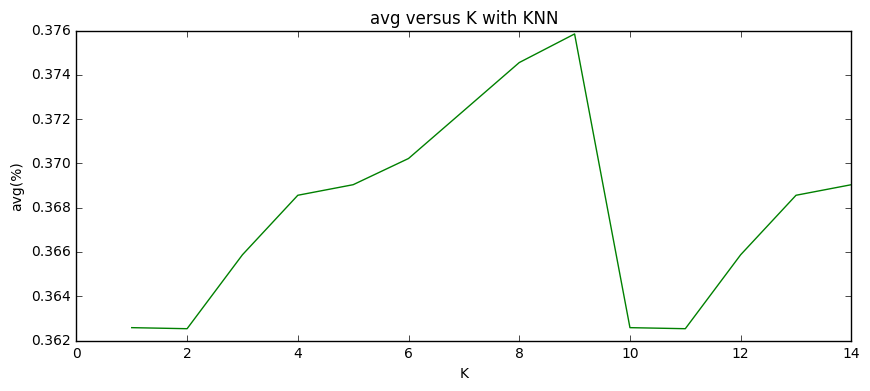

In [32]:
def show_fig():
    fig,ax = plt.subplots() 
    fig.set_size_inches(10, 4)
    plt.plot(testRange, avgs, 'g')
    plt.xlabel('K')
    plt.ylabel('avg(%)')
    plt.title("avg versus K with KNN")
    plt.show()
    plt.close()
show_fig()

In [33]:
ansLabel = run_knn_classify(testSet, bestK)

In [41]:
ans = DF(ansLabel).replace(0, "LOW").replace(1, "MID").replace(2, "HIG")
ans.to_csv('.\\rank\\47_v1.csv', index=False, header=False)

Counter(ans[0])

Counter({'HIG': 1700, 'LOW': 2363, 'MID': 4608})